In [1]:
import pandas as pd
import csv
import re
from datetime import datetime
from functools import reduce
import matplotlib.pyplot as plt

In [2]:
def parseElasticSearchDate(timestamp):
    return datetime.strptime(timestamp, '%b %d, %Y @ %H:%M:%S.%f')

In [3]:
def csvToList(filename, valueKey, timestamp_key="@timestamp"):
    csvList = []
    with open(filename, 'r') as data:  
        for line in csv.DictReader(data):
            timestamp = parseElasticSearchDate(line[timestamp_key])
            csvList.append((timestamp, line[valueKey]))
    return csvList

In [4]:
def closestDatetime(metricList, date):
    return min(metricList, key=lambda x: abs(x[0] - date))

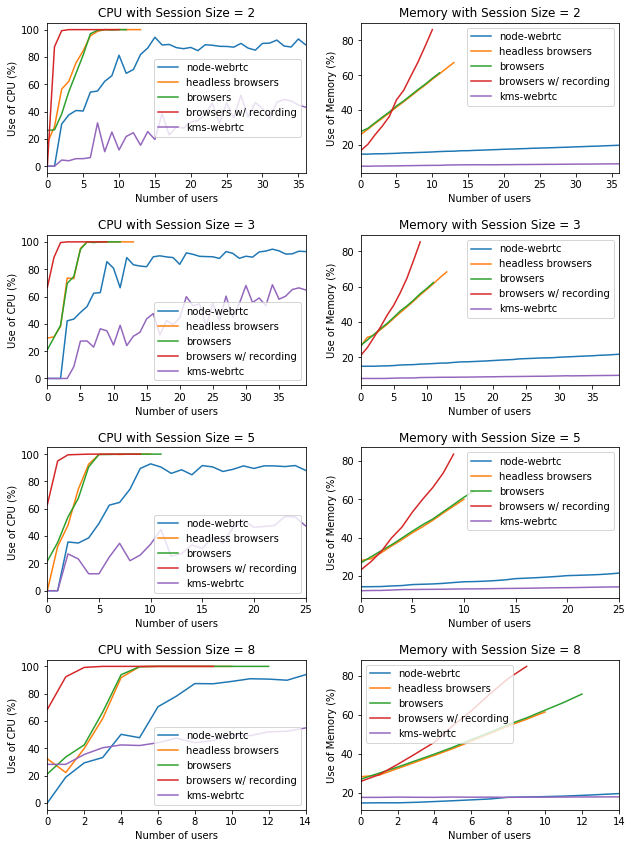

In [20]:
experiments = ["2", "3", "5", "8"]
# Approach with more users should be the first
approaches = ["KMS", "NodeWebRTC", "SeleniumHeadless", "SeleniumWithoutRecording", "SeleniumWithRecording"]

approaches_map = {
    "KMS" : "kms-webrtc",
    "NodeWebRTC" : "node-webrtc", 
    "SeleniumWithRecording" : "browsers w/ recording",
    "SeleniumWithoutRecording" : "browsers",
    "SeleniumHeadless" : "headless browsers"
}

figure, axes = plt.subplots(4, 2)
figure.set_size_inches(9, 12)
row = 0

for sessionSize in experiments:
    
    cpu_dfs = []
    mem_dfs = []
    
    for approach in approaches:
        cpu_path = '%s_Participants_Per_Session/%s/%s_%s_CPU.csv' %  (sessionSize, approach, sessionSize, approach)
        mem_path = '%s_Participants_Per_Session/%s/%s_%s_Mem.csv' %  (sessionSize, approach, sessionSize, approach)
        joined_path = '%s_Participants_Per_Session/%s/%s_%s_Joined.csv' %  (sessionSize, approach, sessionSize, approach)
        cpuList = csvToList(cpu_path, 'system.cpu.total.norm.pct')
        memList = csvToList(mem_path, 'system.memory.used.pct')
        
        unorderJoinedList = []
        with open(joined_path, 'r') as data:  
            for line in csv.DictReader(data):
                timestamp = parseElasticSearchDate(line["timestamp"])
                unorderJoinedList.append(timestamp)
        orderedJoinedList = sorted(unorderJoinedList)
        
        count = 0
        
        data = {
            "users": [],
            "cpu": [],
            "mem": []
        }
        
        for userJoinedTimeStamp in orderedJoinedList:
            count = count + 1
            closestCpuMetric = float(closestDatetime(cpuList, userJoinedTimeStamp)[1][:-1])
            closestMemMetric = float(closestDatetime(memList, userJoinedTimeStamp)[1][:-1])
            data["users"].append(count)
            data["cpu"].append(closestCpuMetric)
            data["mem"].append(closestMemMetric)
        
        cpu_data = {}
        cpu_data["Users"] = data["users"]
        cpu_data[approaches_map[approach]] = data["cpu"]
        cpu_dfs.append(pd.DataFrame(cpu_data))
        
        mem_data = {}
        mem_data["Users"] = data["users"]
        mem_data[approaches_map[approach]] = data["mem"]

        mem_dfs.append(pd.DataFrame(mem_data))
    
    # Generate CPU Chart
    cpu_df = reduce(lambda left,right: left.merge(right, how="left"), cpu_dfs)
    cpu_df = cpu_df.drop(columns=['Users'])
    
    ax_cpu = cpu_df.plot.line(title="CPU with Session Size = %s"%sessionSize, ax = axes[row, 0])
    
    ax_cpu.set_ylabel("Use of CPU (%)")  
    ax_cpu.set_xlabel("Number of users")
    
    # Generate Mem
    mem_df = reduce(lambda left,right: left.merge(right, how="left"), mem_dfs)
    mem_df = mem_df.drop(columns=['Users'])
    ax_mem = mem_df.plot.line(title="Memory with Session Size = %s"%sessionSize, ax = axes[row, 1])
    
    ax_mem.set_ylabel("Use of Memory (%)")
    ax_mem.set_xlabel("Number of users")
    
    row = row + 1

plt.rcParams.update({'font.size': 10 })
figure.tight_layout(pad=1.5)
figure.savefig("images/AllChartsInOne.pdf")

In [54]:
table = []
approaches = ["SeleniumWithoutRecording", "SeleniumWithRecording", "SeleniumHeadless", "NodeWebRTC", "KMS"]
approaches_table_map = {
    "KMS" : "kms-webrtc",
    "NodeWebRTC" : "node-webrtc", 
    "SeleniumWithRecording" : "browser w/ recording",
    "SeleniumWithoutRecording" : "browser",
    "SeleniumHeadless" : "headless browser"
}

max_sessions_map = {}

for sessionSize in experiments:    
    
    for approach in approaches:
        
        joined_path = '%s_Participants_Per_Session/%s/%s_%s_Joined.csv' %  (sessionSize, approach, sessionSize, approach)
        with open(joined_path, 'r') as data:  
            lines = list(csv.DictReader(data))
            # Fill table
            numUsers = len(lines)
            numSessions = int(numUsers/int(sessionSize))
            table.append([sessionSize, approaches_table_map[approach], numSessions, "%d (%d)"%(numSessions*int(sessionSize),numUsers)])
            
            if approaches_table_map[approach] not in max_sessions_map:
                max_sessions_map[approaches_table_map[approach]] = []
            
            max_sessions_map[approaches_table_map[approach]].append(numSessions)
            
df = pd.DataFrame(table)
df.columns =['Session size', 'Testing strategies', 'Max complete Sessions', 'Max users']
df = df.set_index('Session size')
df.to_csv("preliminary_results.csv")
df

,Testing strategies,Max complete Sessions,Max users
Session size,,,
2,browser,6,12 (12)
2,browser w/ recording,5,10 (11)
2,headless browser,7,14 (14)
2,node-webrtc,18,36 (37)
2,kms-webrtc,64,128 (129)
3,browser,4,12 (12)
3,browser w/ recording,3,9 (10)
3,headless browser,4,12 (14)
3,node-webrtc,13,39 (40)


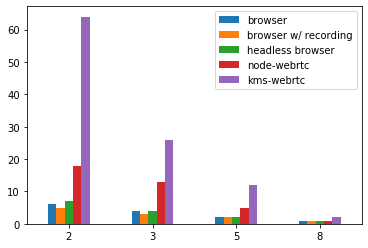

In [55]:
df = pd.DataFrame(max_sessions_map, index=experiments)
ax = df.plot.bar(rot=0)

In [51]:
max_sessions_map

{'SeleniumWithoutRecording': [6, 4, 2, 1],
 'SeleniumWithRecording': [5, 3, 2, 1],
 'SeleniumHeadless': [7, 4, 2, 1],
 'NodeWebRTC': [18, 13, 5, 1],
 'KMS': [64, 26, 12, 2]}

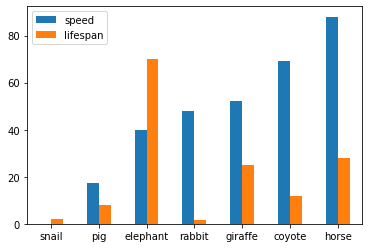

In [44]:
speed = [0.1, 17.5, 40, 48, 52, 69, 88]
lifespan = [2, 8, 70, 1.5, 25, 12, 28]
index = ['snail', 'pig', 'elephant',
         'rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'speed': speed,
                   'lifespan': lifespan}, index=index)
ax = df.plot.bar(rot=0)